Anushna Prakash  
DATA 598 - Deep Learning  
February 4th, 2022  
# <center> Homework 4 </center>  
## 1. Denoising AutoEncoders and Step Decay Learning Rates  

- Use the `MNIST` dataset. Perform the same preprocessing as in this week’s lab.  
- Use the same convolutional autoencoder as in this week’s lab, with a lower latent dimension of 40.  
- As the corruption function $C( \cdot)$, we zero out a randomly chosen $14 \times 14$ patch in the original image. The code for this is provided in the lab again.  
- Train the model for 40 epochs starting with $\gamma_0 = 2.5 \times 10^{−4}$ and take $t_{0} = 10$ (i.e., halve the learning rate every 10 epochs).  

In [1]:
import torch
from torch.nn.functional import relu
from torchvision.datasets import MNIST
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


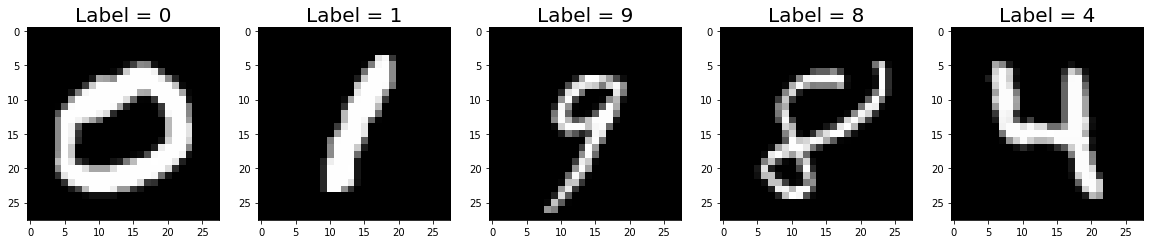

In [15]:
# download dataset (~117M in size)
train_dataset = MNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = MNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize the data
X_train = X_train.float()  # convert to float32
# NOTE: we are returning a single mean/std over all the pixels, rather than a pixel-wise one
mean, std = X_train.mean(), X_train.std()  
X_train = (X_train - mean) / (std + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = (X_test - mean) / (std + 1e-6)

In [5]:
class EncoderModule(torch.nn.Module):
    """
    Encodes batch images into lower dimensional space
    """
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, 1, 28, 28) -> (B, 4, 12, 12)
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=5, stride=2, padding=0) 
        # (B, 4, 12, 12) -> (B, 8, 5, 5)
        self.conv2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=0)
        # Flatten (B, 8, 5, 5) -> (B, 8*5*5): do this in `forward()`
        # (B, 8*5*5) -> (B, lower_dimension); 8*5*5 = 200
        self.linear = torch.nn.Linear(200, lower_dimension)
    
    def forward(self, images):
        out = relu(self.conv1(images))  # conv1 + relu
        out = relu(self.conv2(out))  # conv2 + relu
        out = out.view(out.shape[0], -1)  # flatten
        out = self.linear(out)  # Linear
        return out
    
class DecoderModule(torch.nn.Module):
    """
    Decodes batch images back into original dimensional space
    """
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, lower_dimension) -> (B, linear)
        self.linear_t = torch.nn.Linear(lower_dimension, 200)
        # Unflatten (B, 8*5*5) -> (B, 8, 5, 5); do this in `forward()`
        # Exercise: plug in the output_padding values you determined above
        # (B, 8, 5, 5) -> (B, 4, 12, 12)
        self.conv2_t = torch.nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=0, output_padding=1)
        # (B, 4, 12, 12) -> (B, 1, 28, 28)
        self.conv1_t = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        # Apply in reverse order
        out = relu(self.linear_t(x))  # linear_t + relu
        out = out.view(out.shape[0], 8, 5, 5)  # Unflatten
        out = relu(self.conv2_t(out))  # conv2_t + relu
        out = self.conv1_t(out)  # conv1_t (note: no relu at the end)
        return out

class AutoEncoder(torch.nn.Module):
    """
    Takes images in shape (B, 1, 28, 28)
    Encodes down to (B, 8*5*5) for channels=8 of length lower_dimension
    Decodes up from (B, 8*5*5) back to (B, 1, 28, 28)
    """
    def __init__(self, lower_dimension):
        super().__init__()
        self.encoder = EncoderModule(lower_dimension)
        self.decoder = DecoderModule(lower_dimension)
        
    def forward(self, images):
        encoded_images = self.encoder(images)
        decoded_images = self.decoder(encoded_images)
        return decoded_images
        
    def encode_images(self, images):
        """
        Encode images
        """
        return self.encoder(images)
    
    def decode_representations(self, representations):
        """
        Decode lower-dimensional representation
        """
        return self.decoder(representations)

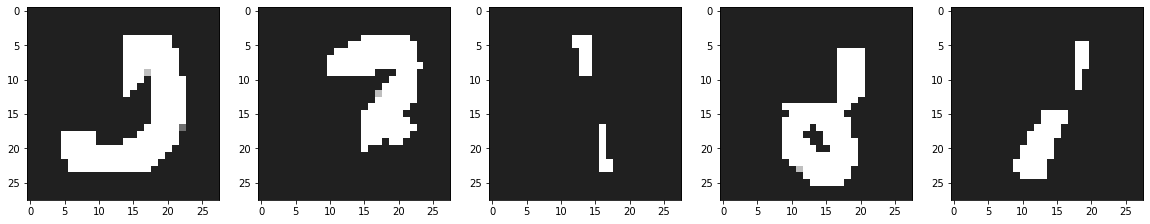

In [16]:
def corrupt_image_batch(images):
    # Add a 10x10 square of zeros in a 28x28 image
    # images: (B, 1, 28, 28)
    patch_size = 14  # zero out a 14x14 patch
    batch_size = images.shape[0]
    height, width = images.shape[-2:]  # height and width of each image
    print(height, ', ', width)
    starting_h = np.random.choice(height - patch_size, size=batch_size, replace=True)
    starting_w = np.random.choice(width - patch_size, size=batch_size, replace=True)

    images_corrupted = images.clone()  # corrupt a copy so we do not lose the originals
    for b in range(batch_size):
        h = starting_h[b]
        w = starting_w[b]
        images_corrupted[b, 0, h:h+patch_size, b:b+patch_size] = 0  # set to 0
    return images_corrupted

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(images_corrupted[i].squeeze() * std + mean, cmap='gray', vmin=0, vmax=255)

In [18]:
X_train.shape

torch.Size([6000, 28, 28])